# What's the Carbon Price of PGE Górnictwo i Energetyka Konwencjonalna S.A. ?

How can we use data from the European Union ETS transaction log retrieved using the EUTL ORM developed by Jan Abrell (https://abrell.eu/). The website https://www.euets.info/ is a human-friendly entry point to the data. The ORM python model can be downloaded from https://github.com/jabrell/eutl_orm. 

A description of the data and of the relational model can be found here: https://euets.info/static/download/Description_EUTL_database.pdf

In this notebook, we concentrate on one single installation/one single "operator holding account".

## To start this notebook

You must have set up the EUTL ORM database locally as explained in the `README.md`.

In [1]:
import sys
sys.path.append('/home/tab/Projects/Hackathon/EUTL_ORM')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from eutl_orm import DataAccessLayer
from eutl_orm import Installation, Account    
from attic import paths
from attic.connection_settings import connectionSettings

%matplotlib inline
plt.rc('xtick', labelsize=14)  #fontsize of the x tick labels
plt.rc('ytick', labelsize=14)  #fontsize of the y tick labels
plt.rc('axes', titlesize=18)  #fontsize of the title
plt.rc('figure', titlesize=20)  #fontsize of the title
plt.rc('axes', labelsize=15)  #fontsize of the axes labels
plt.rc('legend', fontsize=15)  #fontsize of the axes labels

dal = DataAccessLayer(**connectionSettings)
session = dal.session

## Starting point: Bełchatów power station

We start by looking at Bełchatów coal plant, coined by Wikipedia as the "most polluting power plant in the world":
https://en.wikipedia.org/wiki/Be%C5%82chat%C3%B3w_Power_Station



In [2]:
installation_id = "PL_1"
installation = session.query(Installation).get('PL_1')
print(f"{installation.name}")

PGE GiEK S.A. Oddział Elektrownia Bełchatów


In [3]:
compliance_data = installation.get_compliance()
compliance_data = compliance_data[compliance_data.year < 2030]

ax = compliance_data[["year", "allocatedTotal", "verified", "surrendered"]]\
    .set_index("year").div(1000000)\
    .plot(kind="bar", figsize=(10,5), ylabel=r"Million tCO$_2$", grid=True)

## Account Holder: PGE Górnictwo i Energetyka Konwencjonalna S.A.

In [4]:
operator_holding_account = installation.accounts[0]
account_holder = operator_holding_account.accountHolder
account_holder_id = operator_holding_account.accountHolder.id
print(f"Account Holder: {account_holder.name}")

Account Holder: PGE Górnictwo i Energetyka Konwencjonalna S.A.


Retrieve all currently active Operator Holding Account for this Account Holder:

In [5]:
accounts = session.query(Account).filter(Account.accountHolder_id == account_holder_id) \
.filter(Account.accountType_id == "100-7").all()

In [6]:
transaction_tables = []
for account in accounts:
    transaction_tables.append(account.get_transactions())

transactions = pd.concat(transaction_tables)

display(transactions.head())

# add date and datetime information to table (to price transactions with daily ETS price)
transactions["date"] = pd.to_datetime(transactions.index.date)
transactions["datetime"] = pd.to_datetime(transactions.index)

# aggregate transaction blocks into individual transactions
aggregated_transactions = transactions.groupby("transactionID").agg({"amount": "sum", "amount_directed": "sum",
                                                                     "transferringAccount_id": "first",
                                                                     "acquiringAccount_id": "first",
                                                                     "date": "first",
                                                                     "datetime": "first",
                                                                     "acquiringAccountName": "first",
                                                                     "transferringAccountName": "first",
                                                                     "transactionTypeMain": "first",
                                                                     "transactionTypeSupplementary": "first"})


id unitType_id  transferringAccount_id  \
date                                                                   
2012-07-18 12:21:37.480  2229794    EUA_2013                   35750   
2012-07-18 12:21:37.480  2229798    EUA_2013                   35750   
2012-07-18 12:21:37.480  2229797    EUA_2013                   35750   
2012-07-18 12:21:37.480  2229796    EUA_2013                   35750   
2012-07-18 12:21:37.480  2229795    EUA_2013                   35750   

                        project_id  transactionTypeMain_id transactionID  \
date                                                                       
2012-07-18 12:21:37.480        NaN                      10       EU31698   
2012-07-18 12:21:37.480        NaN                      10       EU31698   
2012-07-18 12:21:37.480        NaN                      10       EU31698   
2012-07-18 12:21:37.480        NaN                      10       EU31698   
2012-07-18 12:21:37.480        NaN                      10       EU31698   

                         amount  acquiringAccount_id  \
date                                                   
2012-07-18 12:21:37.480   81000                36161   
2012-07-18 12:21:37.480     386                36161   
2012-07-18 12:21:37.480   75000                36161   
2012-07-18 12:21:37.480   50000                36161   
2012-07-18 12:21:37.480  100000                36161   

                         transactionTypeSupplementary_id  \
date                                                       
2012-07-18 12:21:37.480                                0   
2012-07-18 12:21:37.480                                0   
2012-07-18 12:21:37.480                                0   
2012-07-18 12:21:37.480                                0   
2012-07-18 12:21:37.480                                0   

                                            unitType  \
date                                                   
2012-07-18 12:21:37.480  EU General Allowances (EUA)   
2012-07-18 12:21:37.480  EU General Allowances (EUA)   
2012-07-18 12:21:37.480  EU General Allowances (EUA)   
2012-07-18 12:21:37.480  EU General Allowances (EUA)   
2012-07-18 12:21:37.480  EU General Allowances (EUA)   

                                                       transactionTypeMain  \
date                                                                         
2012-07-18 12:21:37.480  Internal - Internal transfer of unit/supplemen...   
2012-07-18 12:21:37.480  Internal - Internal transfer of unit/supplemen...   
2012-07-18 12:21:37.480  Internal - Internal transfer of unit/supplemen...   
2012-07-18 12:21:37.480  Internal - Internal transfer of unit/supplemen...   
2012-07-18 12:21:37.480  Internal - Internal transfer of unit/supplemen...   

                        transactionTypeSupplementary  \
date                                                   
2012-07-18 12:21:37.480                          NaN   
2012-07-18 12:21:37.480                          NaN   
2012-07-18 12:21:37.480                          NaN   
2012-07-18 12:21:37.480                          NaN   
2012-07-18 12:21:37.480                          NaN   

                                                   acquiringAccountName  \
date                                                                      
2012-07-18 12:21:37.480  PL PGE GiEK S.A. Oddział Elektrownia Bełchatów   
2012-07-18 12:21:37.480  PL PGE GiEK S.A. Oddział Elektrownia Bełchatów   
2012-07-18 12:21:37.480  PL PGE GiEK S.A. Oddział Elektrownia Bełchatów   
2012-07-18 12:21:37.480  PL PGE GiEK S.A. Oddział Elektrownia Bełchatów   
2012-07-18 12:21:37.480  PL PGE GiEK S.A. Oddział Elektrownia Bełchatów   

                             acquiringAccountType  \
date                                                
2012-07-18 12:21:37.480  Operator Holding Account   
2012-07-18 12:21:37.480  Operator Holding Account   
2012-07-18 12:21:37.480  Operator Holding Account   
2012-07-18 12:21:37.480  Operator Holding Account   
2

This list contains all the individual transactions involving an Operator Holding Account (= an installation) belonging to the Account Holder "PGE Górnictwo i Energetyka Konwencjonalna S.A.". We don't whant to price transactions which are internal to the group, since they do not represent a "real" market transaction but a mere re-allocation within an entity.

For that, we identify for each transaction the Account Holder for the "transferring" (from) and the "acquiring" (to) party, and drop all transactions involving the same Account Holder (PGE).

In [7]:
# map all Accounts to their Account Holder
account_to_account_holder = pd.DataFrame(session.query(Account.id, Account.accountHolder_id).all())
account_to_account_holder = account_to_account_holder.dropna()
account_to_account_holder["accountHolder_id"] = account_to_account_holder["accountHolder_id"].astype(int)

# temporary mapping for the Acquiring Account
mapping_tmp = account_to_account_holder.copy()
mapping_tmp = mapping_tmp.rename(columns={"id": "acquiringAccount_id",
                                          "accountHolder_id": "acquiringAccountHolder_id"})

aggregated_transactions = aggregated_transactions.merge(mapping_tmp, how="left", on="acquiringAccount_id")

# temporary mapping for the Transferring Account
mapping_tmp = account_to_account_holder.copy()
mapping_tmp = mapping_tmp.rename(columns={"id": "transferringAccount_id",
                                          "accountHolder_id": "transferringAccountHolder_id"})

aggregated_transactions = aggregated_transactions.merge(mapping_tmp, how="left", on="transferringAccount_id")

# drop all transactions internal to an Account Holder
internal_transactions_sel = aggregated_transactions.acquiringAccountHolder_id == aggregated_transactions.transferringAccountHolder_id
aggregated_transactions = aggregated_transactions[~internal_transactions_sel]

Load daily ETS prices from https://icapcarbonaction.com/en/ets-prices

In [8]:
prices = pd.read_csv(paths.path_data / "ets.csv")
prices["date"] = pd.to_datetime(prices["date"])
prices = prices[["date", "ets_price"]]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(prices.set_index("date"))
ax.grid()
ax.set_ylabel("price [EUR/t]")
ax.set_title("price of EU ETS greenhouse emission allowances")

Text(0.5, 1.0, 'price of EU ETS greenhouse emission allowances')

Price each transaction at the price for this day

In [9]:
aggregated_transactions = aggregated_transactions.merge(prices, on="date")

Assign a price of zero to transactions corresponding to
- the free allocation of allowances
- the deletion of allowances (surrendering)

In [10]:
eu_allocation_account_id = session.query(Account).filter(Account.name == "EU EU ALLOCATION ACCOUNT").first().id
eu_deletion_account_id = session.query(Account).filter(Account.name == "EU EU Allowance deletion").first().id

free_allocation = aggregated_transactions["transferringAccount_id"] == eu_allocation_account_id
deletion = aggregated_transactions["acquiringAccount_id"] == eu_deletion_account_id
aggregated_transactions.loc[free_allocation, "ets_price"] = 0.0
aggregated_transactions.loc[deletion, "ets_price"] = 0.0


Compute the net monetary value of each transaction

In [11]:
# amount_directed > 0 : allowances are transferred TO the installation (e.g. free allocation, purchase...)
# amount_directed < 0 : allowances are transferred FROM the installation (e.g. deletion, sale...)
aggregated_transactions["value"] = aggregated_transactions["ets_price"] * aggregated_transactions["amount_directed"]

Compute the cumulative amount of allowances for the PGE Account Holder and the corresponding cumulative CO2 costs.

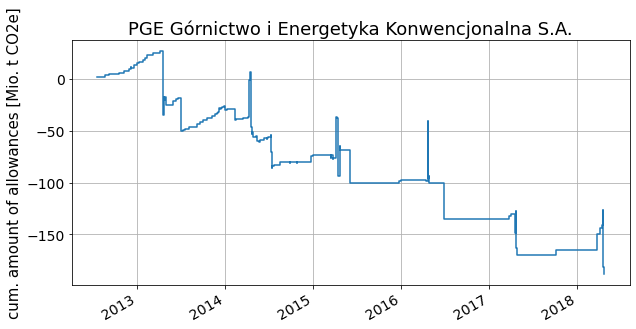

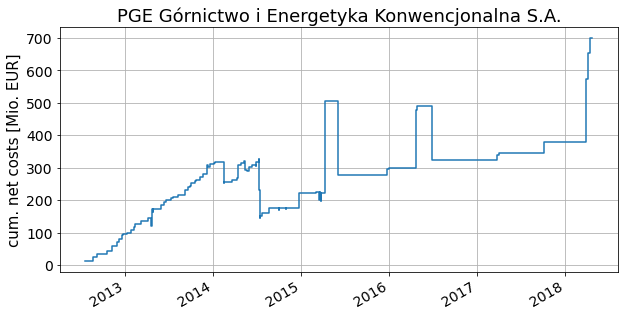

In [12]:
cumulative_value = aggregated_transactions[["datetime", "value"]]
cumulative_value = cumulative_value.groupby("datetime").sum()
cumulative_value = cumulative_value.cumsum()

cumulative_amount = aggregated_transactions[["datetime", "amount_directed"]]
cumulative_amount = cumulative_amount.groupby("datetime").sum()
cumulative_amount = cumulative_amount.cumsum()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cumulative_amount / 1e6, ds="steps-post")
ax.grid()
ax.set_ylabel("cum. amount of allowances [Mio. t CO2e]")
ax.set_title(account_holder.name)
fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cumulative_value / 1e6, ds="steps-post")
ax.grid()
ax.set_ylabel("cum. net costs [Mio. EUR]")
ax.set_title(account_holder.name)
fig.autofmt_xdate()